In [1]:
!git clone https://github.com/Cajeux1999/AEMO-Solar-Energy-Forecasting.git -q

In [30]:
!pip install arfs
from arfs.preprocessing import OrdinalEncoderPandas
import arfs
import arfs.preprocessing as arfspp
import arfs.feature_selection as arfsfs
from arfs.feature_selection.allrelevant import GrootCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from arfs.benchmark import highlight_tick
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [16]:
REPO_NAME = "AEMO-Solar-Energy-Forecasting"
%cd {REPO_NAME}

from src import config, utils
train_size = config.TRAIN_SIZE

#Defining the filepath to load the dataset
filepath_processed = '/content/AEMO-Solar-Energy-Forecasting/data/processed/'
filepath_raw = '/content/AEMO-Solar-Energy-Forecasting/data/raw/'

[Errno 2] No such file or directory: 'AEMO-Solar-Energy-Forecasting'
/content/AEMO-Solar-Energy-Forecasting


In [17]:
#Loading the dataset with the features generated in 2. Feature_Engineering
X = pd.read_csv(filepath_processed+'df_features_preprocessed.csv')
X.drop(columns='Unnamed: 0',inplace=True)

#Loading the target series of solar generation
y = pd.read_csv(filepath_raw+'nsw_solar.csv')

In [14]:
#Instantiating a Cross validation strategy based on TimeSeriesSplit,
#Will be used to feature selection via ARFS
ts_cv = TimeSeriesSplit(
    n_splits=5,
)

In [27]:
#Separating the train sets
X_train = X[:train_size].drop(columns=["ds"])  # se ds for o timestamp
y_train = y[:train_size].drop(columns=["ds","unique_id"]).drop(columns='Unnamed: 0').squeeze()

In [28]:
#Removing some special characters from the features names, that can't be processed by ARFS
X_train = X_train.rename(
    columns=lambda c: re.sub(r'[^A-Za-z0-9_]+', '_', c)
)

Cross Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[111]	training's l2: 48.8615	valid_1's l2: 214939
Groot iteration:  0  with 5 folds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[75]	training's l2: 130.282	valid_1's l2: 88225.6
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[38]	training's l2: 1810.33	valid_1's l2: 148440
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[48]	training's l2: 2137.42	valid_1's l2: 162953
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[34]	training's l2: 6138.36	valid_1's l2: 168266
The selected features: ['y__mean_second_derivative_central' 'y__last_location_of_maximum'
 'y__large_standard_deviation__r_0_30000000000000004'
 'y__partial_autocorrelation__lag_3' 'y__partial_autocorrelation__lag_4'
 'y__partial_autocorre

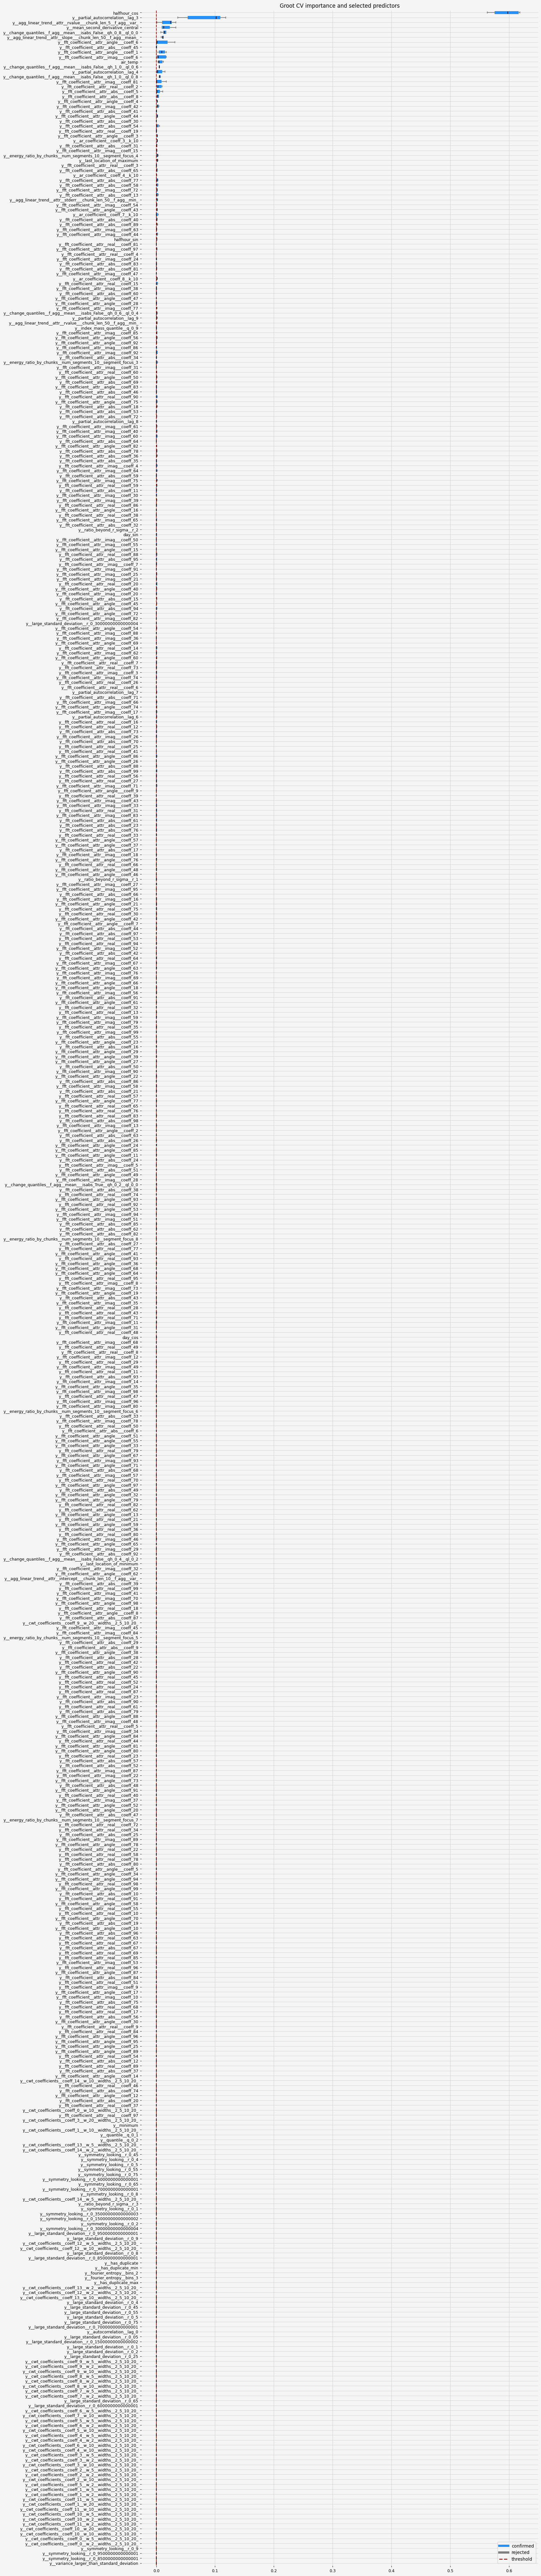

In [35]:
#Instantiate a feature selection method from ARFS
feat_selector = GrootCV(
    objective="rmse",
    cutoff=1.5,
    n_folds=5,
    folds=ts_cv,
    n_iter=5,
    silent=False,
    fastshap=False,
    n_jobs=0,
)

#Shows the selected features
feat_selector.fit(X_train, y_train, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")

fig = feat_selector.plot_importance(n_feat_per_inch=5)
# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

In [37]:
#Transforming the selected features in a list
selected = feat_selector.get_feature_names_out()
selected = list(selected)

In [40]:
X = X.rename(
    columns=lambda c: re.sub(r'[^A-Za-z0-9_]+', '_', c)
)

#Filtering only the selected features to the X dataset
X = X[['ds'] + selected]

In [43]:
X.tail(5)

,ds,y__mean_second_derivative_central,y__last_location_of_maximum,y__large_standard_deviation__r_0_30000000000000004,y__partial_autocorrelation__lag_3,y__partial_autocorrelation__lag_4,y__partial_autocorrelation__lag_6,y__partial_autocorrelation__lag_7,y__partial_autocorrelation__lag_8,y__partial_autocorrelation__lag_9,...,y__agg_linear_trend__attr__rvalue___chunk_len_50__f_agg__min_,y__agg_linear_trend__attr__slope___chunk_len_50__f_agg__mean_,y__agg_linear_trend__attr__stderr___chunk_len_50__f_agg__min_,y__energy_ratio_by_chunks__num_segments_10__segment_focus_3,y__energy_ratio_by_chunks__num_segments_10__segment_focus_4,y__ratio_beyond_r_sigma__r_2,air_temp,halfhour_sin,halfhour_cos,day_sin
8780,2024-12-30 22:00:00,0.0,0.943059,0.0,0.124274,-0.013514,-0.036362,-0.047874,-0.060756,-0.051398,...,0.163323,4.756814,0.000032,0.081234,0.050326,0.034734,24,-0.500000,0.866025,-2.012985e-01
8781,2024-12-30 22:30:00,0.0,0.942951,0.0,0.124279,-0.013510,-0.036363,-0.048125,-0.061135,-0.051840,...,0.163323,4.744690,0.000032,0.081234,0.050752,0.034730,24,-0.382683,0.923880,-2.012985e-01
8782,2024-12-30 23:00:00,0.0,0.942844,0.0,0.124285,-0.013506,-0.036358,-0.048125,-0.061386,-0.052222,...,0.163323,4.733302,0.000032,0.081234,0.051113,0.034726,23,-0.258819,0.965926,-2.012985e-01
8783,2024-12-30 23:30:00,0.0,0.942737,0.0,0.124291,-0.013501,-0.036353,-0.048120,-0.061386,-0.052472,...,0.163323,4.722583,0.000032,0.081234,0.051462,0.034722,23,-0.130526,0.991445,-2.012985e-01
8784,2024-12-31 00:00:00,0.0,0.942629,0.0,0.124297,-0.013497,-0.036348,-0.048114,-0.061380,-0.052472,...,0.163323,4.712476,0.000032,0.081234,0.051786,0.034718,23,0.000000,1.000000,-2.449294e-16


In [42]:
X.to_csv(filepath_processed+'X.csv')